Origin article:  
https://towardsdatascience.com/a-data-science-case-study-with-python-mercari-price-prediction-4e852d95654  

**our objective is to build a model that automatically suggests the right product prices to the sellers.**  

first let's have a look what we have now.

In [10]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
data=pd.read_csv(r"D:\Dropbox\dataforpractice\1.mercari-price-suggestion-challenge\train.tsv",sep='\t')
data.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


We have 8 columns here:  
1. train_id — the id of the product  
2. name — the title of the product  
3. item_condition_id — the condition of the product provided by the sellers  (lower better)  
4. category_name — category of the product  
5. brand_name — the product’s brand name  
6. shipping — 1 if shipping fee is paid by seller and 0 if shipping fee is paid by buyer  
7. item_description — the full description of the product  
8. price — the price that the product was sold for (This is the target variable that we will predict)  

since our goal is to predict price so price is our output.

In [6]:
#split data to two groups
train,test=train_test_split(data,test_size=0.2)
print(train.shape,test.shape)

(1186028, 8) (296507, 8)


In [7]:
#check for missing values
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns
missing_values_table(data)

Your selected dataframe has 8 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
brand_name,632682,42.7
category_name,6327,0.4
item_description,4,0.0


usally we have three method to deal with the missing values:  
1. Remove the records with the missing values.  
2. Remove the feature itself if the number of missing values is higher than some threshold, say 50%.  
3. Consider ‘missing values’ as another category of that respective feature itself.  

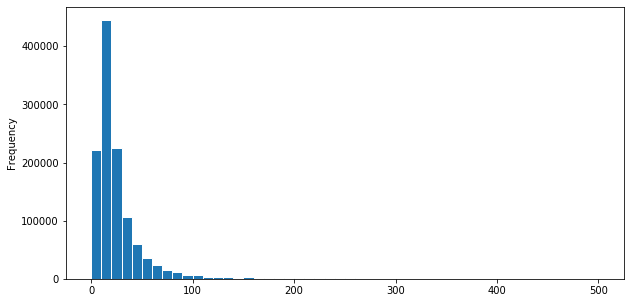

In [14]:
#let's check out how the output price looks like
train['price'].plot.hist(bins=50,figsize=(10,5),range=[0,500],edgecolor='w')
plt.show()
#price distribution is right skewed

In [16]:
train['price'].describe()

count    1.186028e+06
mean     2.673525e+01
std      3.857448e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.006000e+03
Name: price, dtype: float64

In [20]:
train['shipping'].value_counts(normalize=True)*100

0    55.280904
1    44.719096
Name: shipping, dtype: float64

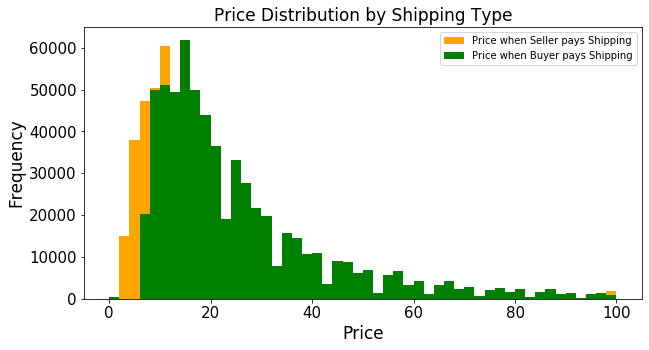

In [23]:
shipping_fee_by_seller = train.loc[train.shipping==1, 'price']
shipping_fee_by_buyer = train.loc[train.shipping==0, 'price']

fig, ax = plt.subplots(figsize=(10,5))
ax.hist(shipping_fee_by_seller, color='Orange', alpha=1.0, bins=50, range=[0,100], label='Price when Seller pays Shipping')
ax.hist(shipping_fee_by_buyer, color='Green', alpha=1.0, bins=50, range=[0,100], label='Price when Buyer pays Shipping')
ax.set(title='Histogram Comparison', ylabel='% of Dataset in Bin')
plt.xlabel('Price', fontsize=17)
plt.ylabel('Frequency', fontsize=17)
plt.title('Price Distribution by Shipping Type', fontsize=17)
plt.tick_params(labelsize=15)
plt.legend()
plt.show()

In [25]:
train['item_condition_id'].value_counts(normalize=True)*100

1    43.227900
3    29.150577
2    25.311375
4     2.149275
5     0.160873
Name: item_condition_id, dtype: float64